In [1]:
import sys
import time

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("C:/Users/haoyuan/Documents/GitHub/CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, groutine

# Create function to do the simulation

In [2]:
def get_kout_with_misalignment(deflect_angle, pulse_obj,
                               misalign_g1=(0., 0., 0.,),
                               misalign_g2=(0., 0., 0.,),
                               misalign_b1=None,
                               misalign_b2=None):
    """
    All the misalignment arguments have a unit of radiant.
    These misalignment are represented with eular angle 'xyz'. I believe that this means that
    the full rotation matrix is constructed by x_rot_mat * y_rot_mat * z_rot_mat.

    However, that should not matter too much, since in this function, there is only one
    rotation around one axis.

    :param deflect_angle:
    :param pulse_obj:
    :param misalign_g1:
    :param misalign_g2:
    :param misalign_b1_c1:
    :param misalign_b1_c2:
    :param misalign_b2_c1:
    :param misalign_b2_c2:
    :return:
    """
    # ----------------------------------------------------------------------------------------------------------
    #                       Step 2: Split
    # ----------------------------------------------------------------------------------------------------------
    grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]

    grating_list[0].set_a(util.get_grating_period(dtheta=deflect_angle, klen_in=pulse_obj.klen0) / 2)
    grating_list[0].set_b(util.get_grating_period(dtheta=deflect_angle, klen_in=pulse_obj.klen0) / 2)
    grating_list[0].rotate_around_surface_point(eular_angle=misalign_g1)

    grating_list[1].set_a(util.get_grating_period(dtheta=deflect_angle, klen_in=pulse_obj.klen0) / 2)
    grating_list[1].set_b(util.get_grating_period(dtheta=deflect_angle, klen_in=pulse_obj.klen0) / 2)
    grating_list[1].rotate_around_surface_point(eular_angle=misalign_g2)

    # ----------------------------------------------------------------------------------------------------------
    #                       Step 3: Delay Lines
    # ----------------------------------------------------------------------------------------------------------
    # Some meta data for the delay line.
    reflect_num = 4
    h_length = 2. * np.pi / (1.9201 * 1e-4)
    hlen_vals = np.array([h_length, ] * reflect_num)

    # Some crystal properties
    chi0 = complex(-0.97631E-05, 0.14871E-06)
    chih_sigma = complex(0.59310E-05, -0.14320E-06)
    chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
    chih_pi = complex(0.46945E-05, -0.11201E-06)
    chihbar_pi = complex(0.46945E-05, -0.11201E-06)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #                       Crystal for branch  1
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Set up the angles
    angle_offset_1 = deflect_angle
    bragg_angle_1 = np.radians(18.836) + 13e-6

    branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                    theta=bragg_angle_1 + np.pi / 2.,
                                                    rho=bragg_angle_1 - np.pi / 2.,
                                                    inclined_angle=np.radians(10.))
    surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

    # Set the misalignment angle

    # Initialize the crystals
    crystal_list_1 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                            theta_vals=branch_angle_1[0],
                                                            rho_vals=branch_angle_1[1],
                                                            tau_vals=branch_angle_1[2],
                                                            surface_points=surface_points_1,
                                                            chi0=chi0,
                                                            chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                            chih_pi=chih_pi, chihbar_pi=chihbar_pi,
                                                            misalign=misalign_b1)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #                       Crystal for branch  2
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Set up the angles
    angle_offset_2 = - deflect_angle
    bragg_angle_2 = np.radians(18.836) + 13e-6

    branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                    theta=1.5 * np.pi - bragg_angle_2,
                                                    rho=0.5 * np.pi - bragg_angle_2,
                                                    inclined_angle=np.radians(0.))
    surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

    # Initialize the crystals
    crystal_list_2 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                            theta_vals=branch_angle_2[0],
                                                            rho_vals=branch_angle_2[1],
                                                            tau_vals=branch_angle_2[2],
                                                            surface_points=surface_points_2,
                                                            chi0=chi0,
                                                            chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                            chih_pi=chih_pi, chihbar_pi=chihbar_pi,
                                                            misalign=misalign_b2)

    # ------------------------------------------------------
    #   Define the positions
    # ------------------------------------------------------
    path_list_1 = [5e6 - 10e4, 1e5, 5e5, 1.05e5, 6e6, 1e6]
    path_list_2 = [5e6, 1e5, 1e5, 1.05e5, 6e6, 1e6]
    delay_time = 800.

    # Adjust the path sections
    (path_list_1,
     path_list_2) = lclsutil.get_split_delay_configuration(delay_time=delay_time,
                                                           fix_branch_path=path_list_2,
                                                           var_branch_path=path_list_1,
                                                           fix_branch_crystal=crystal_list_2,
                                                           var_branch_crystal=crystal_list_1,
                                                           grating_pair=grating_list,
                                                           kin=pulse_obj.k0)
    (intersect_branch_1,
     kout_branch_1,
     intersect_branch_2,
     kout_branch_2) = lclsutil.get_light_path(kin=pulse_obj.k0,
                                              grating_list=grating_list,
                                              crystal_list_1=crystal_list_1,
                                              path_list_1=path_list_1,
                                              crystal_list_2=crystal_list_2,
                                              path_list_2=path_list_2)

    return intersect_branch_1, kout_branch_1, intersect_branch_2, kout_branch_2


# Do the simulation

In [3]:
# ----------------------------------------------------------------------------------------------------------
#                        1: Define pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=0.1,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                         2: Define grating split angle.
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.) 

file_name = "C:/Users/haoyuan/Desktop/Research/Projects/Split Delay Design/instability_inclined_2.h5"

with h5.File(file_name , 'w') as source:
    pass

# Rotate the crystals in the variable branch

In [4]:
# In this simulation, I would like to study the derivation across 10 urad variation.
# The num is the number of partitions I divide the 10 urad into.
num = 100
num_total = 2 * num + 1

axis_list =['x', 'y', 'z']

for c_idx in range(2):  # The crystal index 
    for a_idx in range(3):  # The axis index
        eular_list = np.zeros((num_total, 4, 3), dtype = np.float64)
        if a_idx != 2:
            eular_list[:, 2 * c_idx, a_idx] = np.arange(-num, num+1) * 1e-5 / float(num)
            eular_list[:, 2 * c_idx + 1, a_idx] = np.arange(-num, num+1) * 1e-5 / float(num)
        else:
            eular_list[:, 2 * c_idx, a_idx] = np.arange(-num, num+1) * 1e-5 / float(num)
            eular_list[:, 2 * c_idx + 1, a_idx] = -np.arange(-num, num+1) * 1e-5 / float(num)

        intersect_holder = np.zeros((num_total, 7, 3), dtype=np.float64)
        kout_holder = np.zeros((num_total, 7, 3), dtype=np.float64)

        for idx in range(num_total):
            (intersect_holder[idx],
             kout_holder[idx], 
             _, _ ) = get_kout_with_misalignment(deflect_angle=dtheta,
                                                 pulse_obj=my_pulse,
                                                 misalign_b1=eular_list[idx])

        k_deviation = kout_holder[:,6,:]

        # Save the wave vector difference
        with h5.File(file_name , 'r+') as source:
            source.create_dataset("crystal {} {} axis".format(c_idx, axis_list[a_idx]),
                                  data = k_deviation)

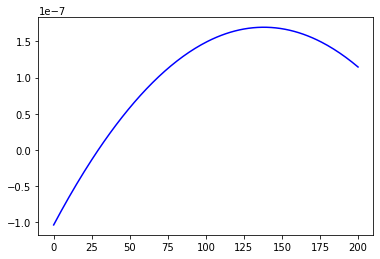

In [5]:
plt.plot(k_deviation[:,0],'b')
#plt.plot(k_deviation[:,1],'k')
#plt.plot(k_deviation[:,2],'r')
plt.show()